# ASBE - Automatic Stopping for Batch Experiments

> API details.

In [ ]:
#hide
from nbdev import *

In [ ]:
%nbdev_default_export core

Cells will be exported to asbe.core,
unless a different module is specified after an export flag: `%nbdev_export special.module`


In [ ]:
%nbdev_export
from modAL.models.base import BaseLearner
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from typing import Union, Optional
from copy import deepcopy
import numpy as np
from pylift.eval import UpliftEval

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%nbdev_export
def random_batch_sampling(classifier, X_pool, n2):
    "Randomly sample a batch from a pool of unlabaled samples"
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples), size=n2)
    return X_pool[query_idx], query_idx

estimator_type = ClassifierMixin
class ASLearner(BaseLearner):
    """A(ctively)S(topping)Learner class for automatic stopping in batch-mode AL"""
    def __init__(self,
                 estimator: estimator_type=None, 
                 query_strategy=None,
                 assignment_fc=None,
                 X_training: np.ndarray = None,
                 t_training: np.ndarray = None,
                 y_training: np.ndarray = None,
                 X_pool: np.ndarray = None
                ) -> None:
        self.estimator = estimator
        self.query_strategy = query_strategy
        self.assignment_fc = assignment_fc
        self.X_training = X_training
        self.y_training = y_training
        self.t_training = t_training
        self.X_pool     = X_pool
        
    def _add_queried_data_class(self, X, t, y):
        self.X_training = np.vstack((self.X_training, X))
        self.t_training = np.concatenate((self.t_training, t))
        self.y_training = np.concatenate((self.y_training, y))
    
    def _update_estimator_values(self):
        self.estimator.__dict__.update(X_training = self.X_training,
                               y_training  =        self.y_training,
                               t_training  =        self.t_training,
                               X_test      =        self.X_pool)

    def teach(self, X_new, t_new, y_new):
        """Teaching new instances to the estimator selected bu the query_strategy
        
        If no `assignment_fc` is added, all selected samples are used
        If assignment function is added, only those instances are used, where
        $\hat{T} = T$
        """
        if self.assignment_fc is None:
            self._add_queried_data_class(X, t_test, y_test)
            self.estimator.fit()
    
    def fit(self):
        self._update_estimator_values()
        self.estimator.fit()
        
    def predict(self, X=None):
        if self.X_pool is not None:
            X = self.X_pool
        elif X is None:
            raise Exception("You need to supply an unlabeled pool of instances (with shape (-1,{}))".format(self.X_training.shape[1]))
        self.preds = self.estimator.predict(X)
        return self.preds
    
    def score(self, preds, y_true, t_true=None, metric = "Qini"):
        """
        Scoring the predictions - either ITE or observed outcomes are needed.
        
        If observed outcomes are provided, the accompanying treatments are also needed.
        """
        if metric == "Qini":
             upev = UpliftEval(t_true, y_true, self.preds[0] if preds is None else preds)
        return upev.

In [ ]:
%nbdev_export
class ITEEstimator(BaseEstimator):
    """ Class for building a naive estimator for ITE estimation
    """
    def __init__(self,
                 model: estimator_type = None,
                 two_model: bool = False,
                 **kwargs
                ) -> None:
        self.model = model
        self.two_model = two_model

    def fit(self,X_training: np.ndarray = None,
                 t_training: np.ndarray = None,
                 y_training: np.ndarray = None,
                 X_test: np.ndarray = None):
        if X_training is not None:
            self.X_training = X_training
            self.y_training = y_training
            self.t_training = t_training
            self.X_test = X_test
        self.N_training = self.X_training.shape[0]
        # if "N_training" not in self.__dict__:
        #     self.N_training = self.X_training.shape[0]
        if self.two_model:
            self.m1 = deepcopy(self.model)
            control_ix = np.where(self.t_training == 0)[0]
            self.model.fit(self.X_training[control_ix,:],
                           self.y_training[control_ix])
            self.m1.fit(self.X_training[-control_ix,:],
                        self.y_training[-control_ix])
        else:
            self.model.fit(np.hstack((self.X_training,
                                      self.t_training.reshape((self.N_training, -1)))),
                           self.y_training)
            
    def predict(self, X=None):
        if X is None:
            X = self.X_test
        if self.two_model:
            self.y1_preds = self.m1.predict_proba(X)[:,1]
            self.y0_preds = self.model.predict_proba(X)[:,1]
        else:
            N_test = X.shape[0]
            self.y1_preds = self.model.predict_proba(
                                np.hstack((X,
                                np.ones(N_test).reshape(-1,1))))[:,1]
            self.y0_preds = self.model.predict_proba(
                np.hstack((X,
                           np.zeros(N_test).reshape(-1,1))))[:,1]
        return self.y1_preds - self.y0_preds, self.y1_preds, self.y0_preds

In [ ]:
X = np.random.normal(size = 1000).reshape((500,2))
t = np.random.binomial(n = 1, p = 0.5, size = 500)
y = np.random.binomial(n = 1, p = 1/(1+np.exp(X[:, 1]*2 + t*3)))
X_test = np.random.normal(size = 200).reshape((100,2))
t_test = np.random.binomial(n = 1, p = 0.5, size = 100)
y_test = np.random.binomial(n = 1, p = 1/(1+np.exp(X_test[:, 1]*2 + t_test*3)))
a = ITEEstimator(LogisticRegression(solver="lbfgs"), two_model = True)
a.fit(X, t, y)
assert type(a.model) == LogisticRegression  # test assigning a model
assert a.X_training.shape  == (500,2)       # test data passing for class
assert a.model.intercept_ is not None

In [ ]:
# a = ITEEstimator(RandomForestClassifier(), X, t, y, X_test, two_model = False )

In [ ]:
asl = ASLearner(estimator = ITEEstimator(model = RandomForestClassifier()), 
         query_strategy=random_batch_sampling,
         X_training=X,t_training=t,y_training=y,X_pool=X_test)
asl.fit()
ite_pred, y1_pred, y0_pred = asl.predict()
X_sel, query_sel = asl.query(asl.X_pool, n2=10)
assert ite_pred.shape[0] == 100
assert X_sel.shape       == (10,2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
asl.teach(X_sel, t_test[query_sel], y_test[query_sel])

In [ ]:
asl.score(preds=None, y_true = y_test, t_true = t_test)

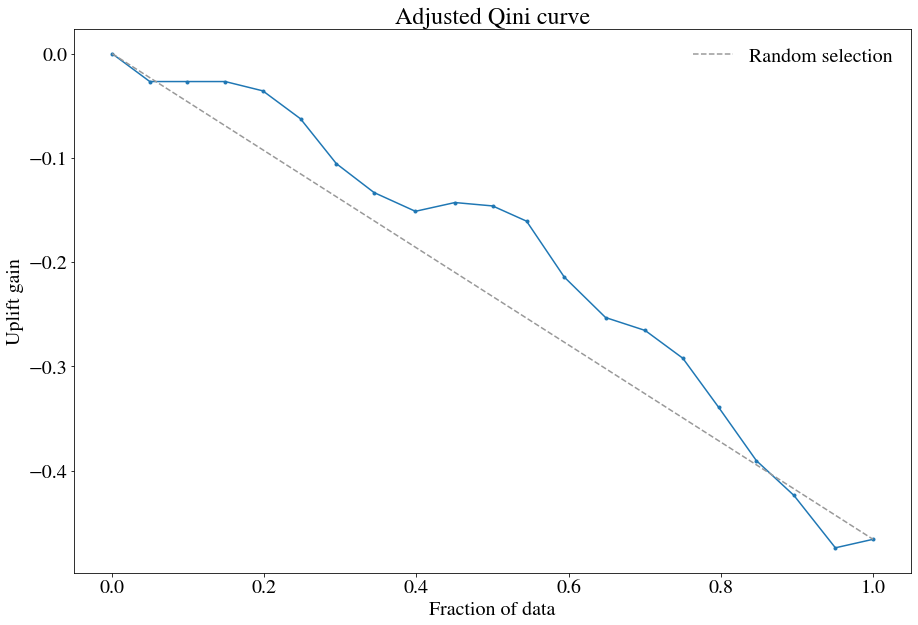

In [ ]:
sc.plot_aqini()